In [1]:
import logging
import warnings
import xarray as xr
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from dask.distributed import Client

from disp_xr.log.logging import setup_logging
from disp_xr import product, quality_metrics, utils, stack as st
from disp_xr.io import write_geotiff, get_geospatial_info

logger = logging.getLogger('disp_xr')
setup_logging(logger_name='disp_xr')

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Get DISP version 0.9 data
disp_df = product.get_disp_info('/u/duvel-d0/ssangha/DISP_work/v11/ADT_tests/F08882/products')

[INFO|product|L23] 2025-02-26T12:21:21-0800: Found OPERA DISP: 74 products


[INFO|product|L42] 2025-02-26T12:21:22-0800:  Starting date: 2016-09-27 00:26:23
[INFO|product|L43] 2025-02-26T12:21:22-0800:  Ending date: 2019-06-20 00:26:36
[INFO|product|L54] 2025-02-26T12:21:22-0800:  Number of reference dates: 4
[INFO|product|L91] 2025-02-26T12:21:22-0800:  Skip 0 duplicates


In [3]:
# Check sizes of ministacks
disp_df.groupby(by='date1').apply(lambda x: x, include_groups=False).groupby(level=0).size()

date1
20160927     3
20161102    26
20171109    29
20181104    16
dtype: int64

In [4]:
# Load stack
stack = st.combine_disp_product(disp_df)


[INFO|stack|L25] 2025-02-26T12:21:42-0800: Stacking into common stack
[INFO|stack|L27] 2025-02-26T12:21:42-0800:  Chunk blocks: {'time': -1, 'x': 512, 'y': 512}
[INFO|logging|L75] 2025-02-26T12:21:58-0800: Total elapsed time for disp_xr.stack.combine_disp_product: 0.27 minutes (16.36 seconds)


In [5]:
# Chunk the data
stack = stack.chunk({'time':30, 'x':512, 'y':512})

In [6]:
from dask.distributed import Client

client = Client(n_workers=6, threads_per_worker=4)
client.dashboard_link

'http://127.0.0.1:8787/status'

In [21]:
client.close()

2025-02-21 21:49:26,422 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-02-21 21:49:26,424 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-02-21 21:49:26,425 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-02-21 21:49:26,427 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-02-21 21:49:26,428 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-02-21 21:49:26,429 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing


In [7]:
def export_stack_quality(output_dir: str | Path, stack_xr:xr.Dataset,
                         quality_var:str, quality_mode:str='mean'):
    
    # Ceck if output dir exists
    out_dir = Path(output_dir)
    out_dir.mkdir(exist_ok=True, parents=True)

    # Get geospatial info
    dataset_path = stack_xr['displacement'].encoding.get('source')
    logger.debug(f'Get bounds and crs from: {Path(dataset_path).name}')
    geo_info = get_geospatial_info(dataset_path)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        
        if quality_var in ['connected_component_labels',
                           'persistent_scatterer_mask',
                           'recommended_mask']:
            reverse = False
            value = 0
            if quality_var == 'persistent_scatterer_mask':
                value = 1
            elif quality_var == 'connected_component_labels': 
                reverse=True

            output = quality_metrics.get_value_percentage(stack_xr[quality_var],
                                                          value=value, reverse=reverse)
            output_filename = out_dir / f'pct_{quality_var}.tif'
        else:
            output = quality_metrics.get_stack_stat(stack_xr[quality_var], quality_mode)
            if quality_var == 'timeseries_inversion_residuals': 
                output /= (2*np.pi)
            output_filename = out_dir / f'{quality_var}_{quality_mode}.tif'

    # Save to local file
    logger.info(f'Saving: {output_filename}')
    write_geotiff(output_filename, np.float32(output),
                  geo_info.bounds, geo_info.crs.to_epsg())

In [7]:
out_dir = '/u/duvel-d2/govorcin/NJ/ASC/v1.1/8621/mintpy/quality_metrics'
export_stack_quality(out_dir, stack, 'phase_similarity','median')

[INFO|quality_metrics|L47] 2025-02-25T13:02:59-0800: Get median of phase_similarity
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  re

In [8]:
export_stack_quality(out_dir, stack, 'phase_similarity','std')

[INFO|quality_metrics|L47] 2025-02-25T13:13:19-0800: Get std of phase_similarity


/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/u/trappist-r0/govorcin/src/to

In [8]:
out_dir = '/u/duvel-d2/govorcin/test'
export_stack_quality(out_dir, stack, 'shp_counts','median')

[INFO|quality_metrics|L47] 2025-02-26T12:22:53-0800: Get median of shp_counts
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/_task_spec.py:740: RuntimeWarning: All-NaN slice encountered
  return s

In [9]:
export_stack_quality(out_dir, stack, 'shp_counts','std')

[INFO|quality_metrics|L47] 2025-02-26T12:27:12-0800: Get std of shp_counts
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/u/trappist-r0/govorcin/src/tools/conda/envs/disp_xr/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encoun

In [80]:
export_stack_quality(out_dir, stack, 'shp_counts','std')

[INFO|quality_metrics|L47] 2025-02-22T01:17:58-0800: Get std of shp_counts
[INFO|1511059712|L36] 2025-02-22T01:21:46-0800: Saving: /u/duvel-d2/govorcin/NJ/ASC/v1.1/28222/mintpy/quality_metrics/shp_counts_std.tif


In [81]:
export_stack_quality(out_dir, stack, 'estimated_phase_quality','median')

[INFO|quality_metrics|L47] 2025-02-22T01:21:47-0800: Get median of estimated_phase_quality


[INFO|1511059712|L36] 2025-02-22T01:27:11-0800: Saving: /u/duvel-d2/govorcin/NJ/ASC/v1.1/28222/mintpy/quality_metrics/estimated_phase_quality_median.tif


In [82]:
export_stack_quality(out_dir, stack, 'estimated_phase_quality','std')

[INFO|quality_metrics|L47] 2025-02-22T01:27:12-0800: Get std of estimated_phase_quality


[INFO|1511059712|L36] 2025-02-22T01:31:13-0800: Saving: /u/duvel-d2/govorcin/NJ/ASC/v1.1/28222/mintpy/quality_metrics/estimated_phase_quality_std.tif


In [83]:
export_stack_quality(out_dir, stack, 'timeseries_inversion_residuals','sum')

[INFO|quality_metrics|L47] 2025-02-22T01:31:14-0800: Get sum of timeseries_inversion_residuals


[INFO|1511059712|L36] 2025-02-22T01:37:39-0800: Saving: /u/duvel-d2/govorcin/NJ/ASC/v1.1/28222/mintpy/quality_metrics/timeseries_inversion_residuals_sum.tif


In [84]:
export_stack_quality(out_dir, stack, 'timeseries_inversion_residuals','mean')

[INFO|quality_metrics|L47] 2025-02-22T01:37:40-0800: Get mean of timeseries_inversion_residuals


[INFO|1511059712|L36] 2025-02-22T01:41:37-0800: Saving: /u/duvel-d2/govorcin/NJ/ASC/v1.1/28222/mintpy/quality_metrics/timeseries_inversion_residuals_mean.tif


In [85]:
export_stack_quality(out_dir, stack, 'persistent_scatterer_mask')

[INFO|quality_metrics|L80] 2025-02-22T01:41:38-0800: Get percentage of persistent_scatterer_mask


[INFO|1511059712|L36] 2025-02-22T01:45:41-0800: Saving: /u/duvel-d2/govorcin/NJ/ASC/v1.1/28222/mintpy/quality_metrics/pct_persistent_scatterer_mask.tif


In [86]:
export_stack_quality(out_dir, stack, 'recommended_mask')

[INFO|quality_metrics|L80] 2025-02-22T01:45:42-0800: Get percentage of recommended_mask


[INFO|1511059712|L36] 2025-02-22T01:49:55-0800: Saving: /u/duvel-d2/govorcin/NJ/ASC/v1.1/28222/mintpy/quality_metrics/pct_recommended_mask.tif


In [87]:
export_stack_quality(out_dir, stack, 'connected_component_labels')

[INFO|quality_metrics|L80] 2025-02-22T01:49:56-0800: Get percentage of connected_component_labels


[INFO|1511059712|L36] 2025-02-22T01:53:48-0800: Saving: /u/duvel-d2/govorcin/NJ/ASC/v1.1/28222/mintpy/quality_metrics/pct_connected_component_labels.tif



## WORKSPACE

In [5]:
# Load stack 

stack = xr.open_mfdataset(disp_df.path.to_list(),
                          data_vars=["temporal_coherence", 
                                     "phase_similarity",
                                     "shp_counts",
                                     "connected_component_labels",
                                     "persistent_scatterer_mask",
                                     "recommended_mask"],
                          combine="by_coords", coords='minimal',
                          compat='override')#, combine_attrs='override') 
stack = stack.chunk({'time':-1, 'x':512, 'y':512})

In [6]:
# Start Dask client 
from dask.distributed import Client

client = Client(threads_per_worker=10)
logger.info(client.dashboard_link)

[INFO|2515771315|L5] 2025-02-21T11:48:01-0800: http://127.0.0.1:8787/status


In [24]:
def export_stack_quality(output_dir: str | Path, stack_xr:xr.Dataset,
                         quality_var:str, quality_mode:str):
    
    # Ceck if output dir exists
    out_dir = Path(output_dir)
    out_dir.mkdir(exist_ok=True, parents=True)

    # Get geospatial info
    dataset_path = stack_xr['displacement'].encoding.get('source')
    logger.debug(f'Get bounds and crs from: {Path(dataset_path).name}')
    geo_info = get_geospatial_info(dataset_path)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        
        if quality_var in ['connected_component_labels',
                           'persistent_scatterer_mask',
                           'recommended_mask']:
            output = QUALITY_METRICS[quality_var](stack_xr)
            output_filename = out_dir / f'pct_{quality_var}.tif'
        else:
            output = QUALITY_METRICS[quality_var](stack_xr, quality_mode)
            output = np.squeeze(output)
            output_filename = out_dir / f'{quality_var}_{quality_mode}.tif'

    # Save to local file
    logger.info(f'Saving: {output_filename}')
    write_geotiff(output_filename, np.float32(output),
                  geo_info.bounds, geo_info.crs.to_epsg())
    

In [ ]:
out_dir = '/u/duvel-d2/govorcin/NJ/ASC/v1.1/8622/mintpy/quality_metrics'
export_stack_quality(out_dir, stack, 'temporal_coherence', 'median')
#export_stack_quality(out_dir, stack, 'temporal_coherence', 'std')

In [ ]:
out_dir = '/u/duvel-d2/govorcin/NJ/ASC/disp_xr_tools/disp_xr_tools/test_quality'
export_stack_quality(out_dir, stack, 'phase_similarity', 'median')
export_stack_quality(out_dir, stack, 'phase_similarity', 'std')

[INFO|quality_metrics|L96] 2025-02-17T13:37:51-0800: Get median phase similarity


[INFO|2067666630|L24] 2025-02-17T13:38:25-0800: Saving: /u/duvel-d2/govorcin/NJ/ASC/disp_xr_tools/disp_xr_tools/test_quality/phase_sim_median.tif
[INFO|quality_metrics|L96] 2025-02-17T13:38:39-0800: Get std phase similarity
[INFO|2067666630|L24] 2025-02-17T13:39:11-0800: Saving: /u/duvel-d2/govorcin/NJ/ASC/disp_xr_tools/disp_xr_tools/test_quality/phase_sim_std.tif


In [25]:
out_dir = '/u/duvel-d2/govorcin/NJ/ASC/disp_xr_tools/disp_xr_tools/test_quality'
export_stack_quality(out_dir, stack, 'shp_counts', 'median')
export_stack_quality(out_dir, stack, 'shp_counts', 'std')

[INFO|quality_metrics|L107] 2025-02-17T13:42:35-0800: Get median shp count
/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/xarray/core/nputils.py:242: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
[INFO|2067666630|L24] 2025-02-17T13:43:15-0800: Saving: /u/duvel-d2/govorcin/NJ/ASC/disp_xr_tools/disp_xr_tools/test_quality/shp_counts_median.tif
[INFO|quality_metrics|L107] 2025-02-17T13:43:29-0800: Get std shp count
/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-package

In [ ]:
out_dir = '/u/duvel-d2/govorcin/NJ/ASC/disp_xr_tools/disp_xr_tools/test_quality'
export_stack_quality(out_dir, stack, 'connected_component_labels', 'median')
export_stack_quality(out_dir, stack, 'persistent_scatterer_mask', 'median')
export_stack_quality(out_dir, stack, 'recommended_mask', 'median')

In [10]:
client.close()

In [40]:
def export_stack_quality(output_dir: str | Path, stack_xr:xr.Dataset,
                         quality_var:str, quality_mode:str):
    
    # Ceck if output dir exists
    out_dir = Path(output_dir)
    out_dir.mkdir(exist_ok=True, parents=True)

    # Get geospatial info
    dataset_path = stack_xr['displacement'].encoding.get('source')
    logger.debug(f'Get bounds and crs from: {Path(dataset_path).name}')
    geo_info = get_geospatial_info(dataset_path)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        
        if quality_var in ['connected_component_labels',
                           'persistent_scatterer_mask',
                           'recommended_mask']:
            output = QUALITY_METRICS[quality_var](stack_xr)
            output_filename = out_dir / f'pct_{quality_var}.tif'
        else:
            output = QUALITY_METRICS[quality_var](stack_xr, quality_mode)
            output_filename = out_dir / f'{quality_var}_{quality_mode}.tif'

    
    return output, output_filename, geo_info
    

In [45]:
o = export_stack_quality(out_dir, stack, 'recommended_mask', 'median')

[INFO|quality_metrics|L71] 2025-02-17T14:35:34-0800: Get percentage of recommended mask


In [54]:
d = quality_metrics.get_phasesim_stat(stack, 'std')

[INFO|quality_metrics|L96] 2025-02-17T14:51:04-0800: Get std phase similarity
/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 687.50 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


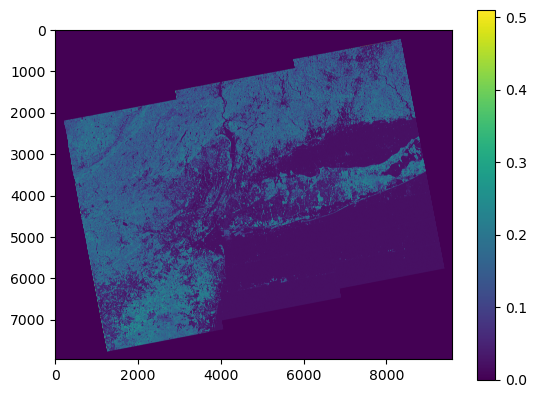

In [55]:
plt.imshow(d)
plt.colorbar()

/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 32.55 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


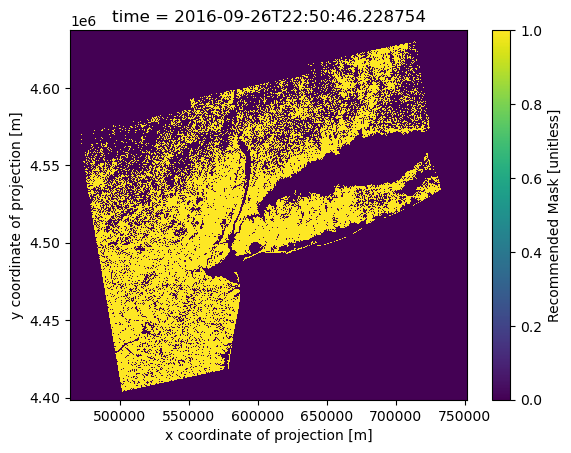

In [50]:
stack.recommended_mask.isel(time=0).plot.imshow()

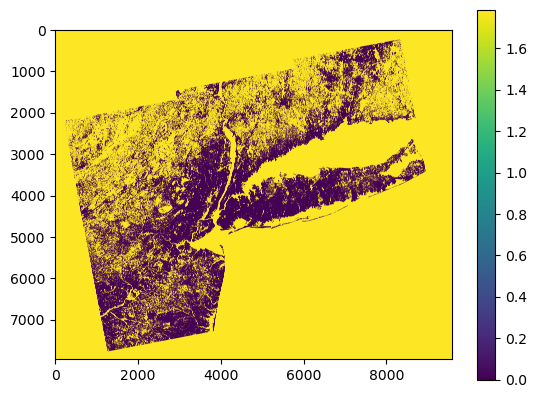

In [46]:
plt.imshow(o[0])
plt.colorbar()

In [72]:
stack

<xarray.Dataset> Size: 71GB
Dimensions:                        (time: 224, y: 7959, x: 9587)
Coordinates:
  * y                              (y) float64 64kB 4.637e+06 ... 4.399e+06
  * x                              (x) float64 77kB 4.641e+05 ... 7.516e+05
  * time                           (time) datetime64[ns] 2kB 2016-09-26T22:50...
Data variables:
    spatial_ref                    int64 8B ...
    reference_time                 (time) datetime64[ns] 2kB dask.array<chunksize=(10,), meta=np.ndarray>
    displacement                   (y, x) float32 305MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    short_wavelength_displacement  (y, x) float32 305MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    recommended_mask               (y, x) float32 305MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    connected_component_labels     (y, x) float32 305MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    temporal_coherence             (time, y, x) float32 68GB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
    estimated_phase_quality        (y, x) float32 305MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    persistent_scatterer_mask      (y, x) float32 305MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    shp_counts                     (y, x) float32 305MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    water_mask                     (y, x) float32 305MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    phase_similarity               (y, x) float32 305MB dask.array<chunksize=(512, 512), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.8
    contact:             opera-sds-ops@jpl.nasa.gov
    institution:         NASA JPL
    mission_name:        OPERA
    reference_document:  JPL D–108765
    title:               OPERA_L3_DISP-S1 Product

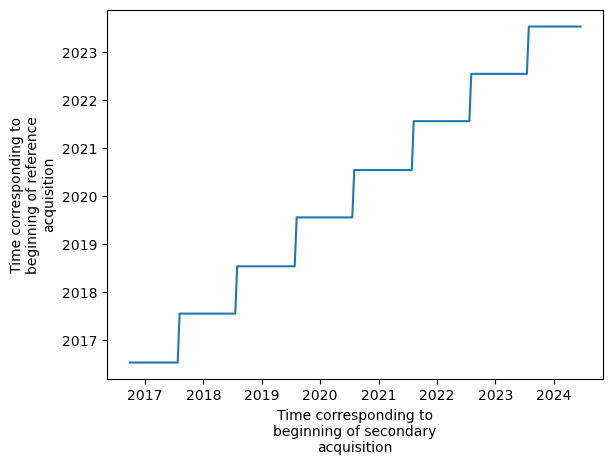

In [56]:
stack.reference_time.plot()

/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 32.55 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


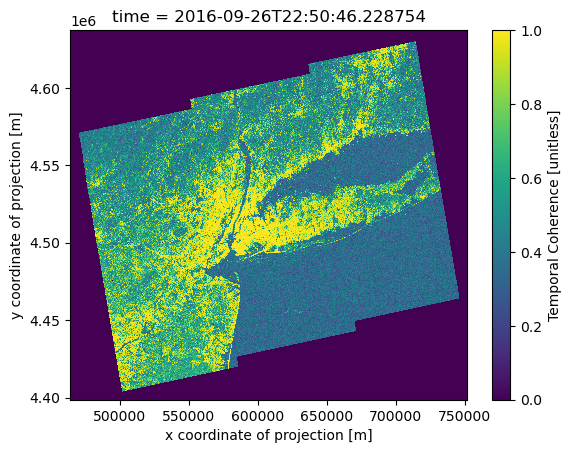

In [62]:
stack.temporal_coherence.isel(time=0).plot.imshow()

/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 13.10 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


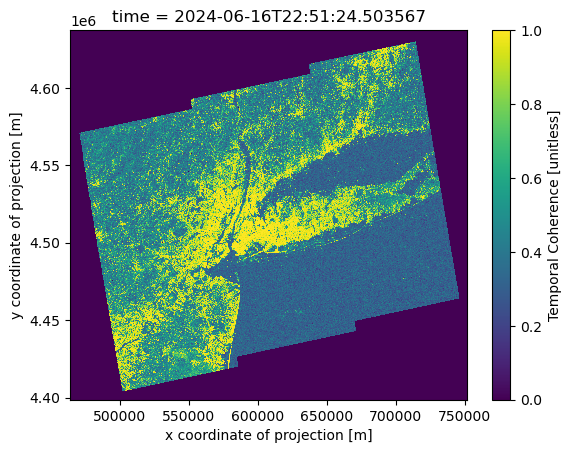

In [63]:
stack.temporal_coherence.isel(time=-1).plot.imshow()

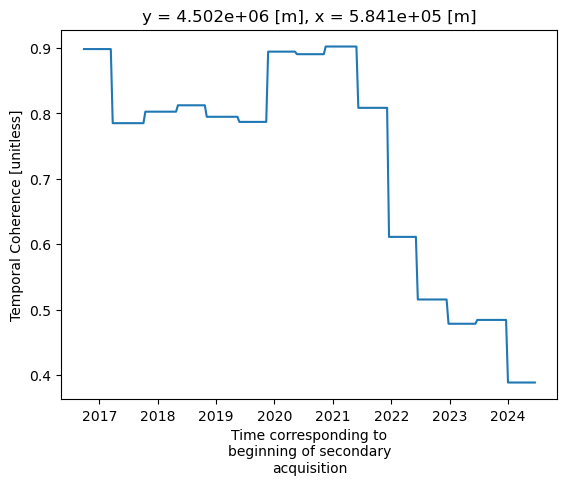

In [64]:
stack.temporal_coherence.isel(x=4000,y=4500).plot()

[INFO|quality_metrics|L118] 2025-02-17T12:31:54-0800: Get mean temporal coherence
/home/govorcin/miniconda3/envs/disp_xr/lib/python3.13/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 13.16 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 23.9 s, sys: 3.98 s, total: 27.9 s
Wall time: 28.1 s


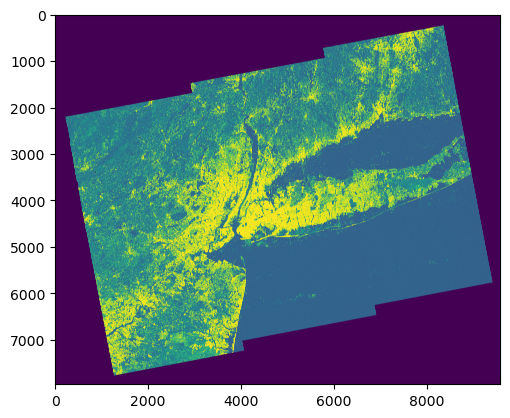

In [61]:
%%time
plt.imshow(QUALITY_METRICS['temp_coh'](stack, 'mean'))